In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler
from keras.layers import BatchNormalization, Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.regularizers import l1
from mlxtend.plotting import plot_decision_regions
from numpy.random import seed
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

2024-06-07 01:11:04.132053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 01:11:04.132238: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 01:11:04.134571: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 01:11:04.164591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 01:11:04.698951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
seed(123)

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [3]:
train_set = pd.read_csv('adult/adult.data', sep=", ", header=None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ", skiprows=1, header=None, engine='python')

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
              'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Szybki preprocessing

In [4]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

/tmp/ipykernel_156453/4187203541.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})
/tmp/ipykernel_156453/4187203541.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['native_country'] = dataset['native_country'].replace(d)


Standaryzacja

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"X_train shape:\t{X_train.shape}")
print(f"X_test shape:\t{X_test.shape}")

X_train shape:	(30162, 41)
X_test shape:	(15060, 41)


In [6]:
# learning rate schedule, adjusts the learning rate over time
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate

In [7]:
history_Adam = History()
model = Sequential()
model.add(Dense(100, activation="sigmoid", input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50, activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10, activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.summary()

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-07 01:11:07.318579: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [9]:
lrate = LearningRateScheduler(step_decay)  # adjust the learning rate over time
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min',
                               verbose=1)  # stop training when a monitored quantity has stopped improving
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100,
          callbacks=[lrate, history_Adam, early_stopping])

Epoch 1/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6448 - loss: 0.6439 - val_accuracy: 0.7543 - val_loss: 0.5366 - learning_rate: 1.0000e-04
Epoch 2/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.7269 - loss: 0.5701 - val_accuracy: 0.7543 - val_loss: 0.4759 - learning_rate: 1.0000e-04
Epoch 3/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.7564 - loss: 0.5024 - val_accuracy: 0.8112 - val_loss: 0.4150 - learning_rate: 1.0000e-04
Epoch 4/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7865 - loss: 0.4525 - val_accuracy: 0.8331 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 5/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.8005 - loss: 0.4314 - val_accuracy: 0.8356 - val_loss: 0.3741 - learning_rate: 1.0000e-04
Epoch 6/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.8081 - loss: 0.4158 - val_accuracy: 0.8366 - val_loss: 0.3660 - learning_rate: 1.0000e-04
Epoch 7/100
943/943 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/

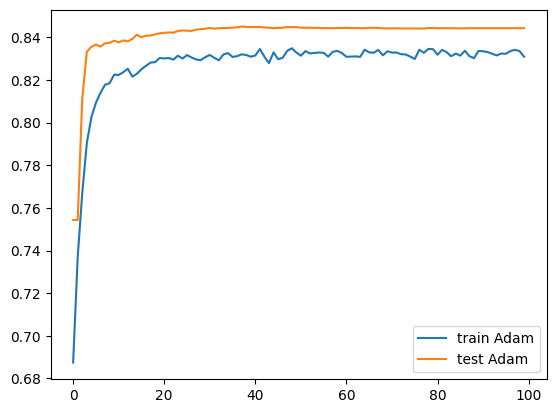

In [10]:
plt.plot(history_Adam.history['accuracy'], label="train Adam")
plt.plot(history_Adam.history['val_accuracy'], label="test Adam")
plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

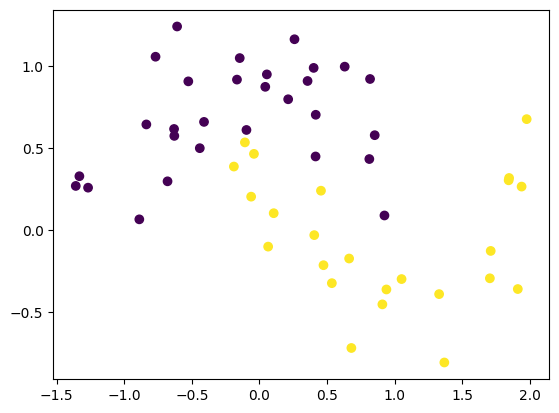

In [11]:
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train = 53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [12]:
def compile_and_fit_model(model, history):
    with tf.device('/GPU:0'):
        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[history])
    return model

In [13]:
# starting model
history_model1 = History()
model1 = Sequential()
model1.add(Dense(1000, activation="relu", input_shape=(X_train.shape[1],)))
model1.add(Dense(500, activation="sigmoid"))
model1.add(Dense(200, activation="sigmoid"))
model1.add(Dense(1, activation="sigmoid"))
model1.summary()

model1 = compile_and_fit_model(model1, history_model1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1000)           │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,901 (2.30 MB)

 Trainable params: 603,901 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4959 - loss: 0.7461 - val_accuracy: 0.4468 - val_loss: 0.8357
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5419 - loss: 0.7404 - val_accuracy: 0.4468 - val_loss: 0.7196
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6069 - loss: 0.6767 - val_accuracy: 0.6383 - val_loss: 0.6410
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6568 - loss: 0.6449 - val_accuracy: 0.7021 - val_loss: 0.6223
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7761 - loss: 0.6041 - val_accuracy: 0.7660 - val_loss: 0.6094
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8117 - loss: 0.5689 - val_accuracy: 0.7234 - val_loss: 0.6180
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7154 - loss: 0.5515 - val_accuracy: 0.7447 - val_loss: 0.5771
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8369 - loss: 0.5114 - val_accuracy: 0.7447 - 

In [14]:
# model with dropout
history_model2 = History()
model2 = Sequential()
model2.add(Dense(1000, activation="relu", input_shape=(X_train.shape[1],)))
model2.add(Dropout(0.8))
model2.add(Dense(500, activation="sigmoid"))
model2.add(Dropout(0.8))
model2.add(Dense(200, activation="sigmoid"))
model2.add(Dropout(0.8))
model2.add(Dense(1, activation="sigmoid"))
model2.summary()

model2 = compile_and_fit_model(model2, history_model2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1000)           │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,901 (2.30 MB)

 Trainable params: 603,901 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.4707 - loss: 1.1519 - val_accuracy: 0.5532 - val_loss: 0.6899
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4855 - loss: 0.9670 - val_accuracy: 0.4468 - val_loss: 0.6915
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5605 - loss: 0.8385 - val_accuracy: 0.4468 - val_loss: 0.7152
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5961 - loss: 0.7330 - val_accuracy: 0.4468 - val_loss: 0.7467
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5167 - loss: 0.9867 - val_accuracy: 0.4468 - val_loss: 0.7832
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5857 - loss: 0.9303 - val_accuracy: 0.4468 - val_loss: 0.7880
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5085 - loss: 0.9193 - val_accuracy: 0.4468 - val_loss: 0.7756
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5939 - loss: 0.6707 - val_accuracy: 0.4468 - 

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

In [15]:
# model with dropout and batch normalization
history_model3 = History()
model3 = Sequential()

model3.add(Dense(1000, input_shape=(X_train.shape[1],)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(0.3))

model3.add(Dense(500))
model3.add(BatchNormalization())
model3.add(Activation("sigmoid"))
model3.add(Dropout(0.3))

model3.add(Dense(200))
model3.add(BatchNormalization())
model3.add(Activation("sigmoid"))
model3.add(Dropout(0.3))

model3.add(Dense(1))
model3.add(BatchNormalization())
model3.add(Activation("sigmoid"))
model.summary()

model3 = compile_and_fit_model(model3, history_model3)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,315 (114.52 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,544 (76.35 KB)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5358 - loss: 0.7058 - val_accuracy: 0.4468 - val_loss: 0.7062
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9059 - loss: 0.4227 - val_accuracy: 0.4468 - val_loss: 0.6999
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9059 - loss: 0.4212 - val_accuracy: 0.4468 - val_loss: 0.6942
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8703 - loss: 0.4111 - val_accuracy: 0.4468 - val_loss: 0.6915
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9037 - loss: 0.3927 - val_accuracy: 0.4468 - val_loss: 0.6896
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8807 - loss: 0.4373 - val_accuracy: 0.4468 - val_loss: 0.6854
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8954 - loss: 0.4120 - val_accuracy: 0.4468 - val_loss: 0.6806
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8599 - loss: 0.4239 - val_accuracy: 0.4468 - 

# Regularyzacja

# Zad.
Do modelu dodaj:

```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```

```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [16]:
history_model4 = History()
model4 = Sequential()
model4.add(Dense(1000, activation="relu", input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model4.add(Dense(500, activation="sigmoid", activity_regularizer=l1(0.00001)))
model4.add(Dense(200, activation="sigmoid", activity_regularizer=l1(0.00001)))
model4.add(Dense(1, activation="sigmoid"))
model4.summary()

model4 = compile_and_fit_model(model4, history_model4)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1000)           │         3,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,901 (2.30 MB)

 Trainable params: 603,901 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4373 - loss: 1.1560 - val_accuracy: 0.4468 - val_loss: 0.7959
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5731 - loss: 0.8129 - val_accuracy: 0.4468 - val_loss: 0.9727
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5523 - loss: 0.8638 - val_accuracy: 0.4468 - val_loss: 0.9095
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5627 - loss: 0.7935 - val_accuracy: 0.4468 - val_loss: 0.7732
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5713 - loss: 0.7531 - val_accuracy: 0.7021 - val_loss: 0.7185
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6568 - loss: 0.7312 - val_accuracy: 0.6170 - val_loss: 0.7117
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6026 - loss: 0.7183 - val_accuracy: 0.7234 - val_loss: 0.6855
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7887 - loss: 0.6726 - val_accuracy: 0.7447 - 

In [17]:
def plot_learning_curves(history, ax=None, label=''):
    ax = ax or plt.gca()
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss ')
    ax.set_title(label)
    ax.set_ylim([0, 1])
    ax.legend()

# Porównanie krzywych uczenia

In [18]:
histories = [history_model1, history_model2, history_model3, history_model4]
labels = ['start', 'dropout', 'dropout + batch normalization', 'regularization']

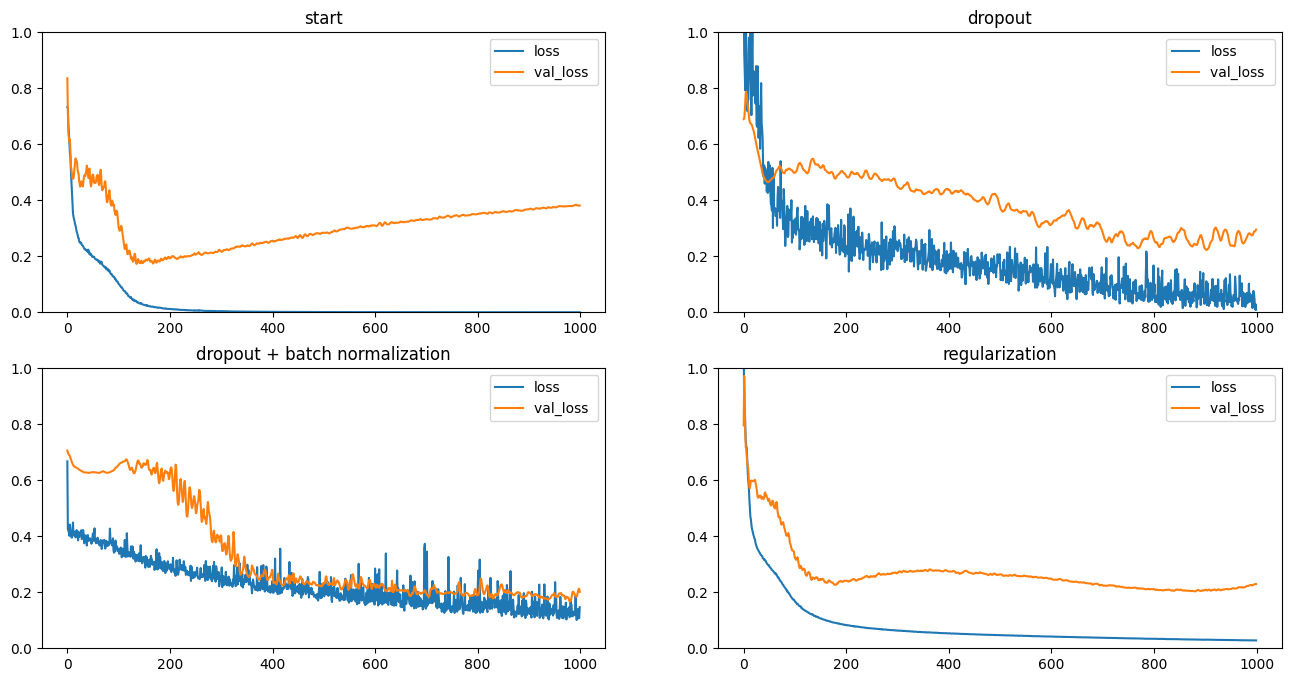

In [19]:
_, axs = plt.subplots(2, 2, figsize=(16, 8))

for model, label, ax in zip(histories, labels, axs.flatten()):
    plot_learning_curves(model, ax, label)

In [55]:
def plot_boundaries(model, *, ax=None, plot_training=True, title=None):
    ax = ax or plt.gca()
    plot_decision_regions(X_test, y_test, model, ax=ax)
    ax.set_title(title)
    if plot_training:
        ax.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'bs', label='train 0')
        ax.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'r^', label='train 1')
        ax.legend()

In [37]:
models = [model1, model2, model3, model4]

40000/40000 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step


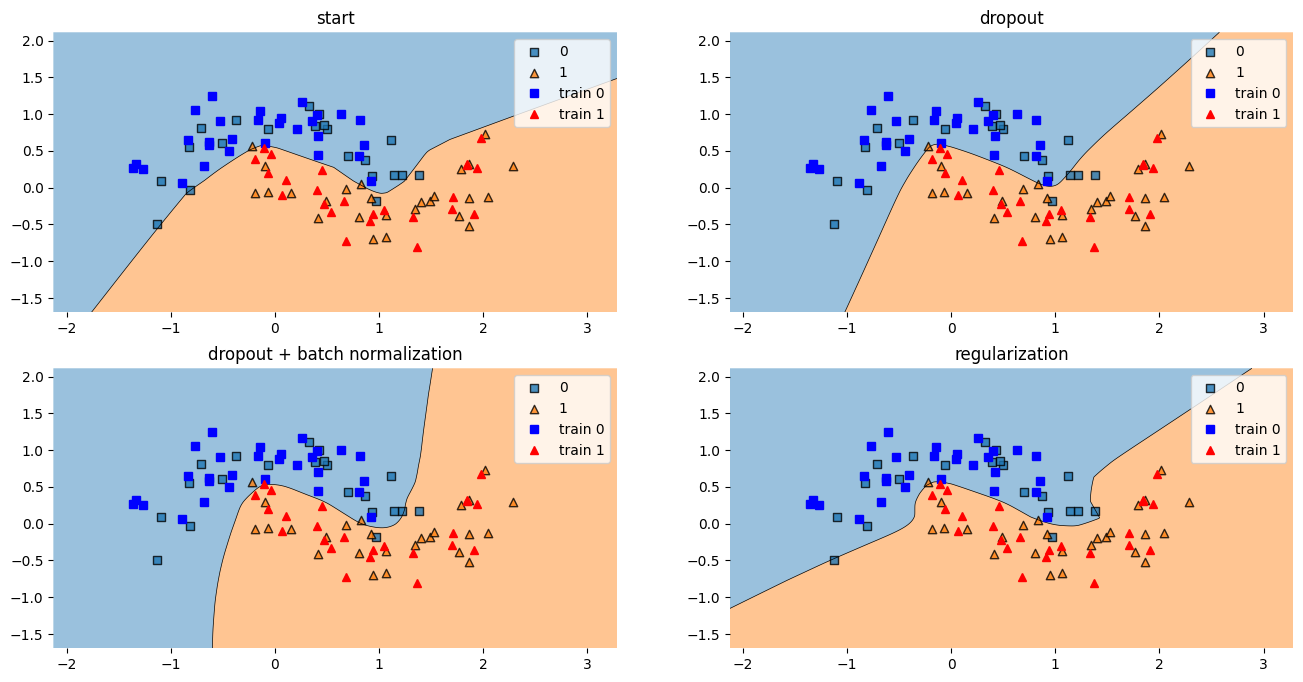

In [57]:
_, axs = plt.subplots(2, 2, figsize=(16, 8))

for model, label, ax in zip(models, labels, axs.flatten()):
    plot_boundaries(model, ax=ax, title=label)